# Import Libraries

In [532]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from datetime import datetime,date,timedelta
from scipy.optimize import curve_fit
import matplotlib.dates as mdates
from functools import partial

# Load Data

In [2]:
path = '/Users/soujanyasamineni/Desktop/COVID-19/csse_covid_19_data/csse_covid_19_time_series/'
all_files = glob.glob(path + "*.csv")
file = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    file.append(df)

data = pd.concat(file, axis=0, ignore_index=True)

/Users/soujanyasamineni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [528]:
all_files[0]

'/Users/soujanyasamineni/Desktop/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

In [529]:
data = pd.read_csv(all_files[0], index_col=None, header=0)

data2  = data.drop(['Lat', 'Long','Province/State'],axis=1)

melted_data = data2.melt(id_vars="Country/Region",var_name='date',value_name='Confirmed')
melted_data['date'] = pd.to_datetime(melted_data['date'])

melted_data.sort_values(by=['Country/Region','date'],inplace=True)

pivoted_data = melted_data.pivot_table(index='Country/Region',columns='date',values='Confirmed',aggfunc=np.sum)

data_china=melted_data[melted_data['Country/Region']=='China']

-----------------------------------------------------------------------------------------------------------------
- **The Bass Model principle is** f(t)/(1-F(t)) = p + q/M (A(t)) 
> "The portion of the potential market that adopts at t given that they have not yet adopted is equal to a linear function of previous adopters."                                        
- *In the above equation, t represents time from product launch and is assumed to be non-negative*.                
- The three Bass Model parameters (coefficients) that define the Bass Model for a specific product are:
- M -- the potential market (the ultimate number of adopters),
- p -- coefficient of innovation and
- q -- coefficient of imitation.

> - M = (-beta(1) +- sqrt(beta(1)*2-4beta(0)beta(2)/(2beta(2))
- p = beta0/m
- q = beta1 + beta0/m


In [28]:
def transition(curve_type,dmax,time_to_max,time_in_lag,launch,time,interval):
    """
    Design a transition curve with given choice of inputs; playing with the parameters p,q
    For more info https://businessperspectives.org/journals/Parametric analysis of the Bass model - Business Perspectives.pdf
    
    :return: transition
    
    """
    scurve=0
    srapidcurve=0
    time_lag=0
#Limit curve type from 0-10
    if curve_type<0:
        curve_type=0
    elif curve_type>10:
        curve_type=10
    else:
        curve_type=curve_type
#Test for pure S curve using lag parameter
    if time_in_lag==0:
        time_lag=time_to_max/4
    else:
        time_lag=time_in_lag
#Calculate weight of curve type
    scurve=1-(curve_type/10)
    srapidcurve=1-scurve
    if time_to_max<0:
        transition=0
    else:
        transition=scurve*S_shape_curve(dmax,time_to_max,time_lag,launch,time,interval)+\
        srapidcurve*rapid_curve(dmax,time_to_max,launch,time,interval)
    return transition

In [29]:
def S_shape_curve(dmax,time_to_max,time_lag,launch,time,interval):
    """
    Design sigmoid curve with given choice of inputs; 
    
    :return: S curve
    
    """
    con,slo=0,0
    lower,upper=0,0
    lower_limit,upper_limit=0,0
    launch=time_index(launch)
    time=time_index(time)
    if time_to_max==time_lag or time_to_max==0:
        if time_to_max<0:
            time_to_max=0
            S_shape_curve=step_func(0,dmax,launch+time_to_max,time,interval)
                
    if interval!=0:
        lower=max(time,launch)
        upper=max(time+interval,launch)
        con=1/(1-time_lag/time_to_max)*np.log((1/0.15-1)/((1/0.98 - 1)**(time_lag/time_to_max)))
        slo=1/time_to_max*(np.log(1/0.98 -1)-con)
        lower_limit=dmax/slo *((con+slo*(lower-launch))-np.log(1+np.exp(con+slo*(lower-launch))))
        upper_limit=dmax/slo *((con+slo*(upper-launch))-np.log(1+np.exp(con+slo*(upper-launch))))
        S_shape_curve=(upper_limit-lower_limit)/interval
    return S_shape_curve

In [30]:
def rapid_curve(dmax,time_to_max,launch,time,interval):
    """
    Design exponential curve with given choice of inputs; 
    
    :return: Exponential curve
    
    """
    launch=time_index(launch)
    time=time_index(time)
    if time_to_max<=0:
        rapid_curve=step_function(0,dmax,launch,time,interval)
    if interval!=0:
        lower=max(time,launch)
        upper=max(time+interval,launch)
        slo=np.log(1-0.98)*-1/time_to_max
        lower_limit=dmax *(lower+1/slo*np.exp(-(slo*(lower-launch))))
        upper_limit=dmax *(upper+1/slo*np.exp(-(slo*(upper-launch))))
        rapid_curve=(upper_limit-lower_limit)/interval
    return rapid_curve

In [32]:
def time_index(time):
    """
    Date in a index format generated by splitting date into year, month and day
    
    :return: time index
    
    """

    if isinstance(time,date):
        time_index=(time.year+(time.month-1)/12 + (time.day-1)/365)
    else:
        if time.isnumeric():
            time_index=time
        else:
            time_index=1/0
    return time_index 

In [33]:
def step_function(start,end,launch,time,interval):
    """
    To model piece-wise constant curve 
    
    :return: step function
    
    """
    if time+interval<=launch:
        step_function=start*interval
    elif time>=launch:
        step_function=end*interval
    else:
        weight=(launch-time)/interval
        step_function=weight*start+(1-weight)*end

In [48]:
datelist = pd.date_range('2019-12-01',end= '2020-12-01',freq='M',name='str').date.tolist()

In [49]:
def transition_curve(datelist, initial_val,final_val, ct,t2p,tlag,tstart):
    """
    transition for set of dates
    
    :return: transition curve
    
    """
    transition_values = []
    for dt in datelist:
        tr_value = initial_val + transition(ct,final_val-initial_val,t2p,tlag,tstart,dt,1/365)
        transition_values.append(tr_value)
    return transition_values

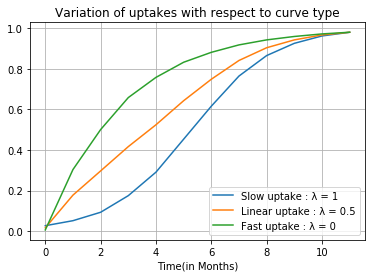

In [531]:
plt.plot(transition_curve(datelist,0,1,0,11/12,0,datelist[0]))
plt.plot(transition_curve(datelist,0,1,5,11/12,0,datelist[0]))
plt.plot(transition_curve(datelist,0,1,10, 11/12,0,datelist[0]))
plt.legend(['Slow uptake : λ = 1','Linear uptake : λ = 0.5','Fast uptake : λ = 0'])
plt.title("Variation of uptakes with respect to curve type")
plt.xlabel("Time(in Months)")
plt.grid(b=True,which='major')
plt.show()

In [496]:
china_data = pivoted_data.loc['China',:]
korea_data=pivoted_data.loc['Korea, South',:]
italy_data=pivoted_data.loc['Italy',:]

In [497]:
xdata = china_data.index
xdata_korea = korea_data.index
xdata_italy = italy_data.index

In [498]:
ydata = china_data.values
ydata_korea = korea_data.values
ydata_italy = italy_data.values

In [500]:
part_transition = partial(transition_curve,tstart=xdata[0])

In [501]:
china_1=china_data.loc[:'2020-02-18']# slope 1
china_2=china_data.loc['2020-02-18':]#slope 2

In [502]:
x1=china_1.index
y1=china_1.values
x2=china_2.index
y2=china_2.values

# Optimization

**China**

In [503]:
# transition_curve(t, initial_val,final_val, ct,t2p,tlag,tstart,freq='M')
popt1, pcov1 = curve_fit(part_transition, x1, y1, bounds=([0,100000,0,0,0], [99999,9999999, 10.,2.,1.8]),
                       p0=[0,200000,0,1/12,0],maxfev=5000)
popt2, pcov2 = curve_fit(part_transition, x2, y2, bounds=([0,0,0,0,0], [99999,9999999, 10.,2.,1.8]),
                       p0=[0,83403,5,1/12,0])

In [504]:
#Change x1 
x1=china_data.index

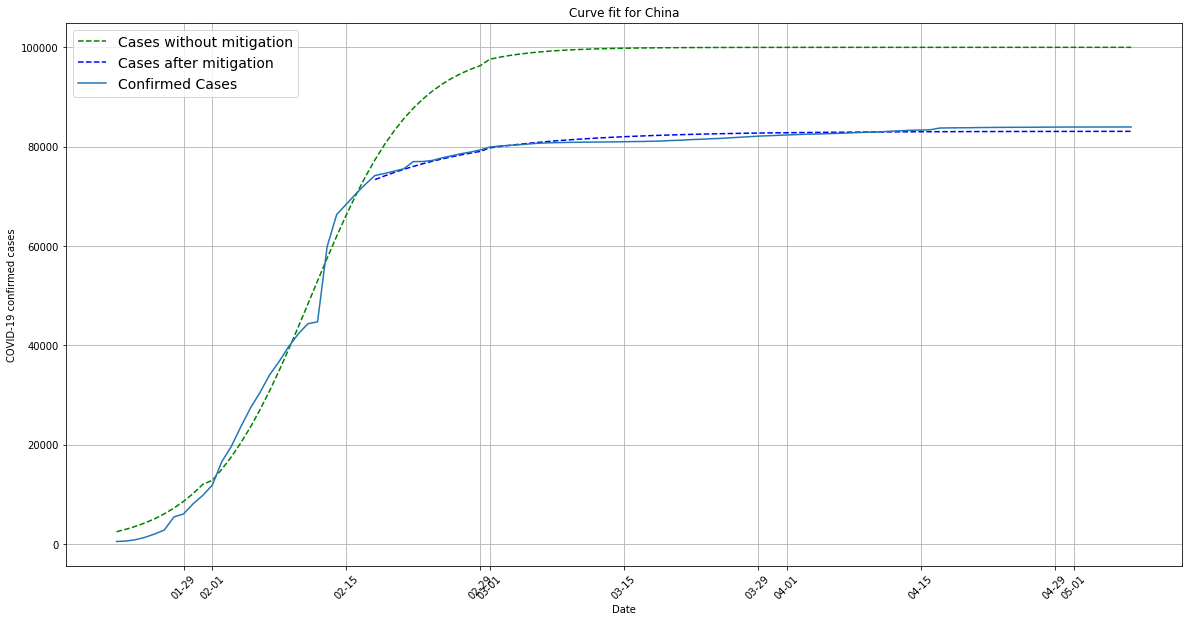

In [505]:
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
plt.plot(x1, part_transition(x1, *popt1), 'g--')
plt.plot(x2, part_transition(x2, *popt2), 'b--')
myFmt = mdates.DateFormatter('%m-%d')
ax.xaxis.set_major_formatter(myFmt)
plt.xlabel('Date')
plt.ylabel("COVID-19 confirmed cases")
plt.plot(xdata,ydata)
plt.grid(which='both')
# for xy in zip(xdata, ydata):                                      
#     ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data') 
plt.title('Curve fit for China')
plt.xticks(rotation=45)
ax.legend(["Cases without mitigation","Cases after mitigation","Confirmed Cases"],prop={'size': 14})
plt.show()

In [507]:
popt2

array([1.72513436e-01, 8.31065809e+04, 9.99999990e+00, 1.34500813e-01,
       5.07793992e-17])

 **Italy**

In [508]:
#2020-04-22
italy_1=italy_data
# italy_2=italy_data.loc['2020-03-19':]
# fig=plt.figure(figsize=(30,20))
# ax = fig.add_subplot(111)
# plt.plot(xdata_italy,ydata_italy)
# for xy in zip(xdata_italy, ydata_italy):                                      
#     ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data') 

In [509]:
x_italy1=italy_1.index
y_italy1=italy_1.values
# x_italy2=italy_2.index
# y_italy2=italy_2.values

In [510]:
part_transition_italy = partial(transition_curve,tstart=xdata_italy[0])

In [511]:
max(italy_1)

215858

In [512]:
popt_italy1, pcov_italy1 = curve_fit(part_transition_italy, x_italy1, y_italy1, bounds=([0,0,0,0,0], [99999,9999999, 10.,2.,1.8]),
                       p0=[0,215858,0,1/12,0])
# popt_italy2, pcov_italy2 = curve_fit(part_transition_italy, x_italy2, y_italy2, bounds=([0,0,0,0,0], [99999,9999999, 10.,2.,1.8]),
#                        p0=[0,215858,5,1/12,0])

In [513]:
x_italy1=italy_data.index

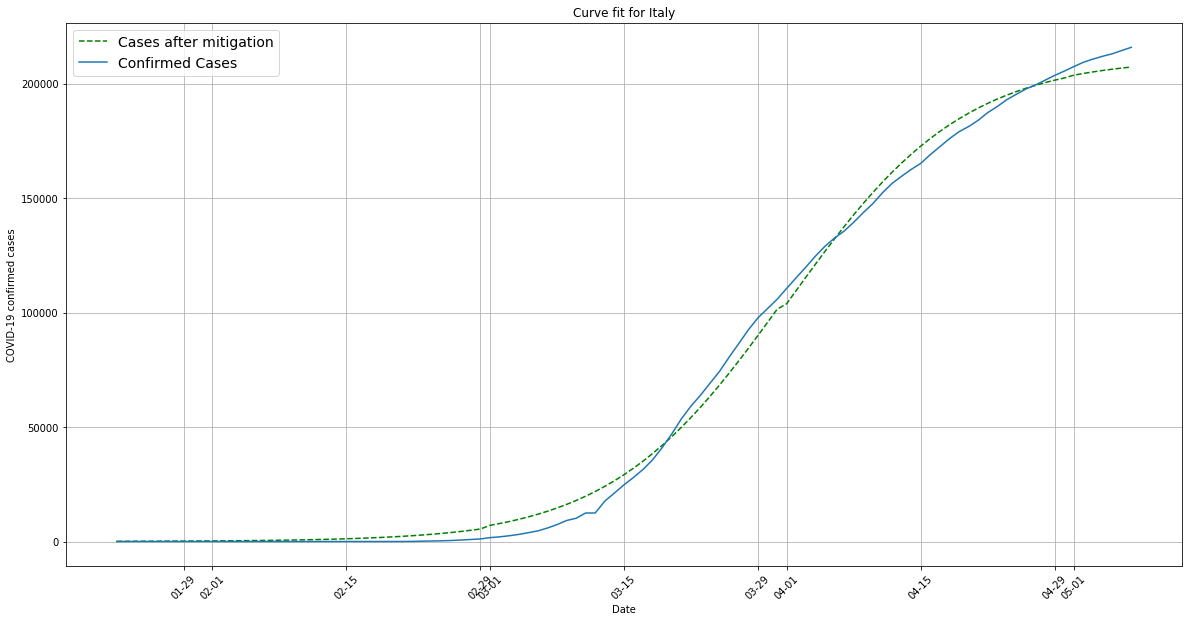

In [514]:
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
plt.plot(x_italy1, part_transition(x_italy1, *popt_italy1), 'g--')

# plt.plot(x_italy2, part_transition(x_italy2, *popt_italy2), 'b--')

plt.plot(xdata_italy,ydata_italy)
plt.grid(which='both')
myFmt = mdates.DateFormatter('%m-%d')
ax.xaxis.set_major_formatter(myFmt)
plt.xlabel('Date')
plt.ylabel("COVID-19 confirmed cases")
plt.title('Curve fit for Italy')
ax.legend(["Cases after mitigation","Confirmed Cases"],prop={'size': 14})
plt.xticks(rotation=45)
plt.show()

In [515]:
popt_italy1

array([2.06834245e-10, 2.11211628e+05, 1.22852156e-13, 2.92003358e-01,
       1.51279507e-01])

**Korea**

In [516]:
korea_1=korea_data.loc[:'2020-03-09']
korea_2=korea_data.loc['2020-03-09':]
# fig=plt.figure(figsize=(30,20))
# ax = fig.add_subplot(111)
# plt.plot(xdata_korea,ydata_korea)
# for xy in zip(xdata_korea, ydata_korea):                                      
#     ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

In [517]:
x_korea1=korea_1.index
y_korea1=korea_1.values
x_korea2=korea_2.index
y_korea2=korea_2.values

In [518]:
part_transition_korea = partial(transition_curve,tstart=xdata_korea[0])

In [519]:
max(korea_2)

10822

In [520]:
popt_korea1, pcov_korea1 = curve_fit(part_transition_korea, x_korea1, y_korea1, bounds=([0,15000,0,0,0], [99999,9999999, 10.,2.,1.8]),
                       p0=[0,15000,0,11/12,1/12])
popt_korea2, pcov_korea2 = curve_fit(part_transition_korea, x_korea2, y_korea2, bounds=([0,0,0,0,0], [99999,9999999, 10.,2.,1.8]),
                       p0=[0,10822,5,1/12,0])

In [521]:
x_korea1=korea_data.index

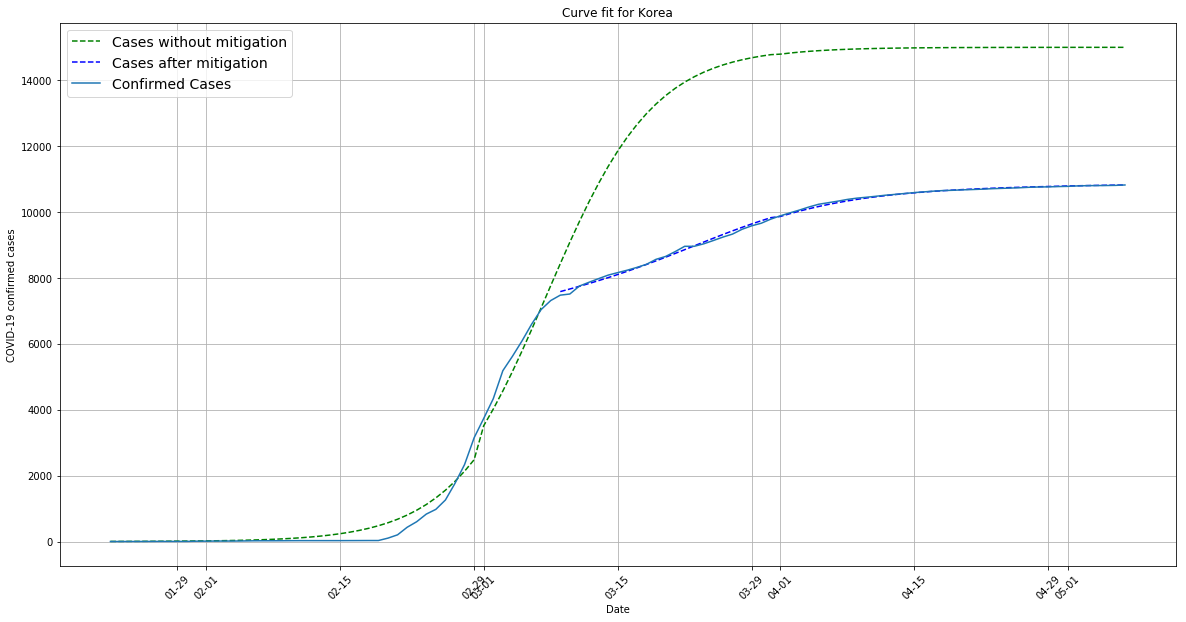

In [523]:
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
plt.plot(x_korea1, part_transition(x_korea1, *popt_korea1), 'g--')
plt.plot(x_korea2, part_transition(x_korea2, *popt_korea2), 'b--')
myFmt = mdates.DateFormatter('%m-%d')
ax.xaxis.set_major_formatter(myFmt)
plt.plot(xdata_korea,ydata_korea)
plt.grid(which='both')
plt.xlabel("Date")
plt.ylabel("COVID-19 confirmed cases")
plt.title('Curve fit for Korea')
ax.legend(["Cases without mitigation","Cases after mitigation","Confirmed Cases"],prop={'size': 14})
plt.xticks(rotation=45)
plt.show()

In [526]:
popt_korea2


array([4.98737190e-01, 1.09065753e+04, 7.65877440e+00, 2.47087666e-01,
       1.40861752e-01])